## In class Exercise 5
The purpose of this exercise is to practice different ML algorithms for text classification, text clustering, and model evaluation.

Hint: You might want to use the code demos from previous lectures, where suitable.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due tonight December 6th, 2023 at 11:59 PM.
**Late submissions cannot be considered.**

### Question 1.

The purpose of this question is to practice different machine learning algorithms for text classification, along with performance evaluation. In addition, you are requried to conduct *10 fold cross validation (https://scikit-learn.org/stable/modules/cross_validation.html)* in the training.

The dataset (see Canvas) contains two files train data and test data for sentiment analysis in IMDB review, and it has two categories: 1 represents positive and 0 represents negative.

You need to split the training data into training and validation data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model needs to be evaluated on the test data.

Algorithms:
1. MultinominalNB (2 points)
2. SVM (2 points)
3. KNN (2 points)
4. Decision tree (2 points)
5. Random Forest (2 points)
6. XGBoost (2 points)

Evaluation measurement:
1. Accuracy (2 points)
2. Recall (2 points)
3. Precison (2 points)
4. F-1 score (2 points)

In [17]:
# Write your code here
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings

nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')


def read_data(file_path):
    text_data, sentiments = [], []
    file_data = open(file_path).read()
    for i, j in enumerate(file_data.split("\n")):
        after_split = j.split(' ')
        text_data.append(" ".join(after_split[1:]))
        sentiments.append(after_split[0])
    return text_data, sentiments


def preprocess_data(data_frame):
    # Convert sentiment classes to integers
    data_frame['Sentimental Value'] = pd.to_numeric(data_frame['Sentimental Value'], errors='coerce')

    # Drop rows with NaN values in the target variable
    data_frame = data_frame.dropna(subset=['Sentimental Value'])

    # Pre-processing
    # removal of special characters
    data_frame['After noise removal'] = data_frame['Raw Data'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', char) for char in x))

    # removal of Punctuation
    data_frame['Punctuation removal'] = data_frame['After noise removal'].str.replace('[^\w\s]', '')

    # Stopwords removal
    stop_word = stopwords.words('english')
    data_frame['Stopwords removal'] = data_frame['Punctuation removal'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_word))

    # Lower Casing
    data_frame['Lower casing'] = data_frame['Stopwords removal'].apply(lambda x: " ".join(word.lower() for word in x.split()))

    return data_frame


def vectorize_data(train_df, test_df):
    # TF-IDF Vectorization
    tfidf_vector = TfidfVectorizer(analyzer='word')
    tfidf_vector.fit(train_df['Lower casing'])
    x_train = tfidf_vector.transform(train_df['Lower casing'])
    tfidf_vector_test = TfidfVectorizer(analyzer='word', vocabulary=tfidf_vector.vocabulary_)
    tfidf_vector_test.fit(test_df['Lower casing'])
    x_test = tfidf_vector_test.transform(test_df['Lower casing'])

    return x_train, x_test


def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    predicted = classifier.predict(x_test)
    accuracy = accuracy_score(predicted, y_test)
    print(f"Accuracy of Testing data ({classifier.__class__.__name__}): {accuracy}")

    if 'XGB' not in str(classifier):
        scoring = 'accuracy'
        kfold = KFold(10, random_state=7, shuffle=True)
        cross_val = cross_val_score(classifier, x_test, y_test, cv=kfold, scoring=scoring).mean()
        print(f"Cross-validation score ({classifier.__class__.__name__}): {cross_val}")

    print(f"\nClassification Report ({classifier.__class__.__name__}):\n")
    print(classification_report(y_test, predicted))


# Read data
training_text_data, training_sentiments = read_data('stsa-train.txt')
testing_text_data, testing_sentiments = read_data('stsa-test.txt')

# Create data frames
training_df = pd.DataFrame(list(zip(training_sentiments, training_text_data)), columns=['Sentimental Value', 'Raw Data'])
testing_df = pd.DataFrame(list(zip(testing_sentiments, testing_text_data)), columns=['Sentimental Value', 'Raw Data'])

# Pre-process data
training_df = preprocess_data(training_df)
testing_df = preprocess_data(testing_df)

# Vectorize data
x_train, x_test = vectorize_data(training_df, testing_df)

# Split data for training and testing
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, training_df['Sentimental Value'],
                                                                      test_size=0.2, random_state=42)

# Ensure target variables are integers
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)

# List of classifiers
classifiers = [
    naive_bayes.MultinomialNB(),
    svm.SVC(),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Evaluate each classifier on the test set
for classifier in classifiers:
    print(f"Evaluating {classifier.__class__.__name__} on the test set:")
    evaluate_classifier(classifier, x_train, y_train, x_test, testing_df['Sentimental Value'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Evaluating MultinomialNB on the test set:
Accuracy of Testing data (MultinomialNB): 0.7924217462932455
Cross-validation score (MultinomialNB): 0.7254368582237435

Classification Report (MultinomialNB):

              precision    recall  f1-score   support

         0.0       0.87      0.69      0.77       912
         1.0       0.74      0.90      0.81       909

    accuracy                           0.79      1821
   macro avg       0.81      0.79      0.79      1821
weighted avg       0.81      0.79      0.79      1821

Evaluating SVC on the test set:
Accuracy of Testing data (SVC): 0.7990115321252059
Cross-validation score (SVC): 0.7089683540503213

Classification Report (SVC):

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       912
         1.0       0.77      0.85      0.81       909

    accuracy                           0.80      1821
   macro avg       0.80      0.80      0.80      1821
weighted avg       0.80      0.80  

### Question 2.

The purpose of the question is to practice different machine learning algorithms for text clustering.

Please downlad the dataset by using the following link: https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones

Apply the listed clustering methods to the dataset:
1. K-means (4 points)
2. DBSCAN (4 points)
3. Hierarchical clustering (4 points)
4. Word2Vec (4 points)
5. BERT (4 points)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape: (413840, 6)


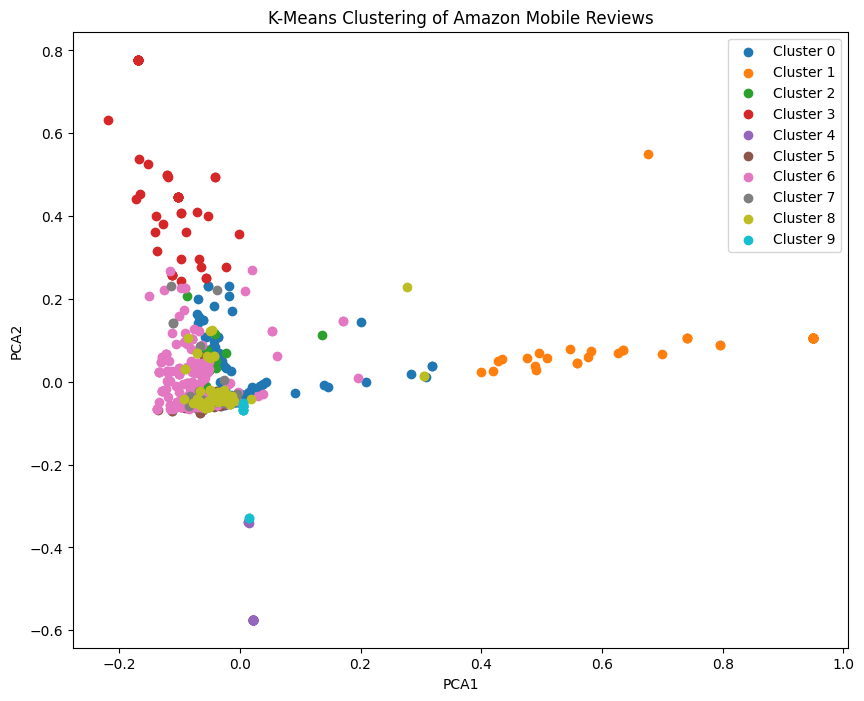

0.39528026327024723
The two reviews assigned to cluster  0
----------------------------------------------------------------------
I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


nice phone, nice up grade from my pantach revue. Very clean set up and easy set up. never had an android phone but they are fantastic to say the least. perfect size for surfing and social media. great phone samsung


______________________________________________________________________
The two reviews assigned to cluster  1
----------------------------------------------------------------------
100% gooddd!


fino fino


____________________________________________________________________

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


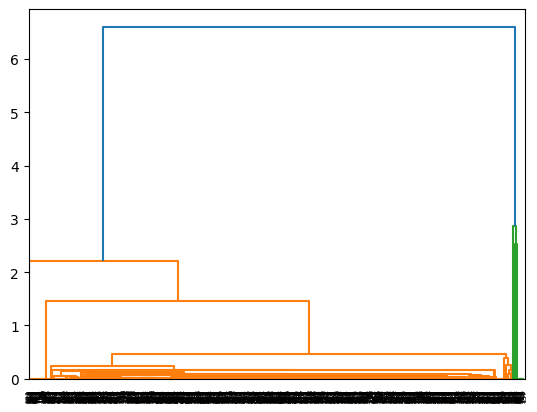

In [24]:
# Import libraries
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
nltk.download('wordnet')
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Read data
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
print("Shape: {0}".format(df.shape))
cluster_data_df = df.head(1000)
cluster_data_df

# Text preprocessing
from sklearn import metrics
cluster_data_df['After noise removal'] = cluster_data_df['Reviews'].apply(lambda x: ''.join(re.sub(r"[^a-zA-Z0-9]+", ' ', charctr) for charctr in x ))
cluster_data_df['Punctuation removal'] = cluster_data_df['After noise removal'].str.replace('[^\w\s]','')
cluster_data_df['Remove numbers'] = cluster_data_df['Punctuation removal'].str.replace('\d+', '')
stop_word = stopwords.words('english')
cluster_data_df['Stopwords removal'] = cluster_data_df['Remove numbers'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_word))
cluster_data_df['Lower casing'] = cluster_data_df['Stopwords removal'].apply(lambda x: " ".join(x.lower() for x in x.split()))
cluster_data_df['Tokenization'] = cluster_data_df['Lower casing'].apply(lambda x: TextBlob(x).words)
st = PorterStemmer()
cluster_data_df['Stemming'] = cluster_data_df['Tokenization'].apply(lambda x: " ".join([st.stem(word) for word in x]))
cluster_data_df['Lemmatization'] = cluster_data_df['Stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(cluster_data_df['Lemmatization'].values)

# K-Means Clustering
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters=10, random_state=99)
model_tf.fit(tfidf)
labels_tf = model_tf.labels_
cluster_center_tf = model_tf.cluster_centers_
terms1 = tfidf_vect.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf.toarray())

# Create a DataFrame with the reduced features and cluster labels
cluster_data_pca = pd.DataFrame(tfidf_pca, columns=['PCA1', 'PCA2'])
cluster_data_pca['Cluster'] = labels_tf

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(10):  # Adjust the range based on the number of clusters
    cluster_points = cluster_data_pca[cluster_data_pca['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Cluster {cluster}')

plt.title('K-Means Clustering of Amazon Mobile Reviews')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# K-means - Method 2
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(cluster_data_df['Reviews'].values)
bow.shape

from sklearn.cluster import KMeans
model = KMeans(n_clusters=10, init='k-means++', random_state=99)
model.fit(bow)
labels = model.labels_
cluster_center = model.cluster_centers_

from sklearn import metrics
print(metrics.silhouette_score(bow, labels, metric='euclidean'))

cluster_data_df['Bow Clus Label'] = model.labels_  # the last column you can see the label numbers
cluster_data_df.head(2)

# DBSCAN clustering
from sklearn.cluster import DBSCAN
import numpy as np
minPts = 2 * 100
def lower_bound(nums, target):
    l, r = 0, len(nums) - 1
    while l <= r:
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data):
    dists = []
    for val in data:
        dist = np.sum((x - val) ** 2)
        if len(dists) == 200 and dists[199] > dist:
            l = int(lower_bound(dists, dist))
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()

    return dists[199]

list_of_trains_sent = list()
for i in cluster_data_df["Lower casing"].values:
    list_of_trains_sent.append(i.split())

import gensim
w2v_model = gensim.models.Word2Vec(list_of_trains_sent, vector_size=100, workers=4)


from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize


list_of_sent_train = cluster_data_df['Lower casing'].apply(lambda x: x.split())
sent_vectors = []

for sent in list_of_sent_train:
    sent_vec = np.zeros(100)
    cnt_words = 1
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = normalize(sent_vectors)

# Computing the 200th nearest neighbour distance of some point in the dataset:
twohundredthneighbour = []
for val in sent_vectors[:300]:
    twohundredthneighbour.append(compute200thnearestneighbour(val, sent_vectors[:300]))

twohundredthneighbour.sort()

# Training DBSCAN:
model_dbscan = DBSCAN(eps=5, min_samples=minPts, n_jobs=-1)
model_dbscan.fit(sent_vectors)
cluster_data_df['AVG-W2V Clus Label'] = model_dbscan.labels_
cluster_data_df.head(2)

# Hierarchical Clustering
import scipy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

dendro = hierarchy.dendrogram(hierarchy.linkage(sent_vectors, method='ward'))
plt.axhline(y=10)  # cut at 30 to get 5 clusters

from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg = cluster.fit_predict(sent_vectors)

# Giving Labels/assigning a cluster to each point/text
aggdfa = cluster_data_df
aggdfa['AVG-W2V Clus Label'] = cluster.labels_

# Count of points belonging to each cluster
aggdfa.groupby(['AVG-W2V Clus Label'])['Reviews'].count()

# Reading a review which belong to each group
for i in range(5):
    print("The two reviews assigned to cluster ", i)
    print("-" * 70)
    for j in [0, 1]:
        print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][j]]['Reviews'])
        print('\n')
    print("_" * 70)

#Word2vec
import gensim
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import nltk
nltk.download('punkt')
import numpy as np

# Preprocessing steps may include tokenization, lowercasing, removing stop words, punctuation, etc.
cluster_data_df['Tokenized_Reviews'] = cluster_data_df['Reviews'].apply(lambda x: nltk.word_tokenize(x.lower()))
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=cluster_data_df['Tokenized_Reviews'], vector_size=100, window=5, min_count=1, workers=4)
# Vectorize each review
vectors = [word2vec_model.wv[word] for word in cluster_data_df['Tokenized_Reviews']]
vectors_concatenated = np.array([np.concatenate(review_vectors) for review_vectors in vectors])

# Ensure all concatenated vectors have the same shape by padding or truncating if needed
max_vector_length = max(len(vec) for vec in vectors_concatenated)
vectors_padded = np.array([np.pad(vec, ((0, max_vector_length - len(vec))), mode='constant') if len(vec) < max_vector_length else vec[:max_vector_length] for vec in vectors_concatenated])

# Apply dimensionality reduction with PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors_padded)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5)
kmeans.fit(vectors_2d)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to your dataset
cluster_data_df['cluster'] = cluster_labels

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and obtain embeddings for each review
embeddings = []
max_length = 512  # Adjust this based on the model's maximum token limit

for review in cluster_data_df['Reviews']:
    inputs = tokenizer(review, return_tensors="pt", truncation=True, max_length=max_length)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    mean_embedding = torch.mean(last_hidden_states, dim=1).squeeze().detach().numpy()
    embeddings.append(mean_embedding)

# Apply KMeans clustering to BERT embeddings
bert_kmeans = KMeans(n_clusters=5, random_state=42)
bert_clusters = bert_kmeans.fit_predict(np.array(embeddings))

# Add BERT cluster labels to your dataset
cluster_data_df['BERT_Cluster'] = bert_clusters

In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.

In [ ]:
#You can write you answer here. (No code needed)
K-means is a fast and efficient approach, although it needs specified clusters and is sensitive to outliers.
DBSCAN is not outlier sensitive, although choosing the right density threshold might be difficult.
Hierarchical clustering, however computationally costly, may efficiently discover many clusters in large datasets.
While Word2Vec is a handy tool for vectorizing words, it does not consider word context.
BERT is a powerful model that can capture human language changes, despite its high computing cost and requirement for extensive training data.
